# 1. Import Modules

In [128]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

import os
import re
import json
import glob
from collections import defaultdict
from textblob import TextBlob
from functools import partial

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

import nltk
import spacy
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])
nlp.max_length = 4000000

from nltk.probability import FreqDist
from wordcloud import WordCloud, STOPWORDS

from tqdm.autonotebook import tqdm
import string

%matplotlib inline
os.listdir(r'C:\kaggle\coleridge\data')
nlp.max_length = 10411675

# 2. Data Exploration

### Files
   + train - the full text of the training set's publications in JSON format, broken into sections with section titles
   + test - the full text of the test set's publications in JSON format, broken into sections with section titles
   + train.csv - labels and metadata for the training set
   + sample_submission.csv - a sample submission file in the correct format

In [100]:
train_df = pd.read_csv("train.csv")
sample_sub = pd.read_csv("sample_submission.csv")
test_path = "C:/kaggle/coleridge/data/test"
train_path = "C:/kaggle/coleridge/data/train"

In [101]:
train_df.head()

,Id,pub_title,dataset_title,dataset_label,cleaned_label
0,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,The Impact of Dual Enrollment on College Degre...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
1,2f26f645-3dec-485d-b68d-f013c9e05e60,Educational Attainment of High School Dropouts...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
2,c5d5cd2c-59de-4f29-bbb1-6a88c7b52f29,Differences in Outcomes for Female and Male St...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
3,5c9a3bc9-41ba-4574-ad71-e25c1442c8af,Stepping Stone and Option Value in a Model of ...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
4,c754dec7-c5a3-4337-9892-c02158475064,"Parental Effort, School Resources, and Student...",National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study


### Columns
+ id - publication id - note that there are multiple rows for some training documents, indicating multiple mentioned datasets
+ pub_title - title of the publication (a small number of publications have the same title)
+ dataset_title - the title of the dataset that is mentioned within the publication
+ dataset_label - a portion of the text that indicates the dataset
+ cleaned_label - the dataset_label, as passed through the clean_text function from the Evaluation page

In [102]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19661 entries, 0 to 19660
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             19661 non-null  object
 1   pub_title      19661 non-null  object
 2   dataset_title  19661 non-null  object
 3   dataset_label  19661 non-null  object
 4   cleaned_label  19661 non-null  object
dtypes: object(5)
memory usage: 768.1+ KB


In [103]:
[print(f"{col}:{len(train_df[col].unique())}") for col in train_df.columns]

Id:14316
pub_title:14271
dataset_title:45
dataset_label:130
cleaned_label:130


[None, None, None, None, None]

In [104]:
def read_append_jashon(filename, train_path=train_path, output='text'):
    jason_path = os.path.join(train_path, (filename)+'.json')
    headings = []
    contents = []
    combined = []
    
    with open(jason_path, 'r') as f:
        jason_decode = json.load(f)
        for data in jason_decode:
            headings.append(data.get('section_title'))
            contents.append(data.get('text'))
            combined.append(data.get('section_title'))
            combined.append(data.get('text'))
            
    all_headings = ' '.join(headings)
    all_contents = ' '.join(contents)
    all_data = ' '.join(combined)
        
    if output == 'text':
        return all_contents
    
    elif output == 'head':
        return all_headings
    
    else:
        return all_data

In [105]:
%%time
tqdm.pandas()
train_df['text'] = train_df['Id'].progress_apply(read_append_jashon)


Wall time: 2min 12s


In [106]:
train_df.sample(10)

,Id,pub_title,dataset_title,dataset_label,cleaned_label,text
13836,3cdde32f-7f13-4e6b-944d-8c5e70517d7e,Young Children's Access to Computers in the Ho...,Early Childhood Longitudinal Study,Early Childhood Longitudinal Study,early childhood longitudinal study,As computers become more prevalent and compute...
3434,a26fd879-c781-458d-8ce1-6aa50fb5c483,"Imago Mundi, Imago AD, Imago ADNI",Alzheimer's Disease Neuroimaging Initiative (A...,ADNI,adni,Since the launch in 2003 of the Alzheimer's Di...
17628,9fb1afb4-1c62-4fdb-9c16-ac8f80472db7,USDA Forest Service National Woodland Owner Su...,Census of Agriculture,Census of Agriculture,census of agriculture,The National Woodland Owner Survey (NWOS) is c...
4010,bc8e966f-26f5-49ce-aa13-05c7c95c1634,Increased CNV-Region deletions in mild cogniti...,Alzheimer's Disease Neuroimaging Initiative (A...,ADNI,adni,We investigated the genome-wide distribution o...
12415,26b6976f-bae1-4841-98bd-d60f10ed221e,Perceptions and Application of NCTM Standards ...,Common Core of Data,Common Core of Data,common core of data,grounded in a common set of challenging standa...
8253,c9ea111b-dd69-40cb-be44-e50c91c29299,Availability of and Access to Career Developme...,Education Longitudinal Study,Education Longitudinal Study,education longitudinal study,Equipping youth with and without disabilities ...
17243,dfaa678a-dae0-467f-ac95-0ae9e888c162,Farm Adaptation at the Rural-Urban Interface,Census of Agriculture,Census of Agriculture,census of agriculture,Despite population growth and development at t...
2978,93fcecc2-35a2-4dcc-bf10-371c680c1ec6,"Socio-economic, behavioural and environmental ...",Early Childhood Longitudinal Study,Early Childhood Longitudinal Study,early childhood longitudinal study,Recent increases in obesity prevalence among c...
16660,167fa53d-a5e4-4fe4-956e-32942571b7fb,Early Childhood Disadvantage for Sons of Mexic...,Early Childhood Longitudinal Study,Early Childhood Longitudinal Study,early childhood longitudinal study,developmental context of early childhood. The ...
665,c632606f-923a-4f4f-8d41-91475b53b08f,Severity of inducible myocardial ischemia pred...,Baltimore Longitudinal Study of Aging (BLSA),Baltimore Longitudinal Study of Aging (BLSA),baltimore longitudinal study of aging blsa,Background. Although the severity of inducible...


In [107]:
sample_sub.head()

,Id,PredictionString
0,2100032a-7c33-4bff-97ef-690822c43466,NaN
1,2f392438-e215-4169-bebf-21ac4ff253e1,NaN
2,3f316b38-1a24-45a9-8d8c-4e05a42257c6,NaN
3,8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60,NaN


In [108]:
%%time
tqdm.pandas()
sample_sub['text'] = sample_sub["Id"].progress_apply(read_append_jashon, train_path=test_path)


Wall time: 102 ms


In [109]:
sample_sub.head()

,Id,PredictionString,text
0,2100032a-7c33-4bff-97ef-690822c43466,NaN,Cognitive deficits and reduced educational ach...
1,2f392438-e215-4169-bebf-21ac4ff253e1,NaN,This report describes how the education system...
2,3f316b38-1a24-45a9-8d8c-4e05a42257c6,NaN,"Cape Hatteras National Seashore (CAHA), locate..."
3,8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60,NaN,A significant body of research has been conduc...


### 3. Data Cleansing

In [110]:
def text_cleansing(text):
    text = ''.join([k for k in text if k not in string.punctuation])
    text = re.sub('[^A-Za-z0-9]+', ' ', str(text).lower()).strip()
    text = re.sub(' +', ' ', text)
    emoji = re.compile("[" 
                       u"\U0001F600-\U0001F64F" 
                       u"\U0001F300-\U0001F5FF"  
                       u"\U0001F680-\U0001F6FF" 
                       u"\U0001F1E0-\U0001F1FF"
                       "]+", flags=re.UNICODE)
    
    text = emoji.sub(r'', text)
    return text



In [111]:
%%time
tqdm.pandas()
train_df['text'] =  train_df['text'].progress_apply(text_cleansing)


Wall time: 5min 12s


In [112]:
%%time
tqdm.pandas()
sample_sub['text'] = sample_sub['text'].progress_apply(text_cleansing)


Wall time: 173 ms


### 4. Data Vizualization

In [121]:
words = list(train_df['cleaned_label'].values)
stopwords=['ourselves', 'hers','the','of','and','in', 'between', 'yourself', 'but', 'again','of',
           'there', 'about', 'once', 'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 
           'be', 'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 'other', 
           'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves', 
           'until', 'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 'nor', 'me', 'were', 'her', 
           'more', 'himself', 'this', 'down', 'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 
           'had', 'she', 'all', 'no', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 
           'on', 'does', 'yourselves', 'then', 'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not', 
           'now', 'under', 'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'myself', 'which', 'those',
           'i', 'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 
           'how', 'further', 'was', 'here', 'than']

split_words = []
for word in words:
    lo_w = []
    list_of_words = str(word).split()
    for w in list_of_words:
        if w not in stopwords:
            lo_w.append(w)
    split_words.append(lo_w)
allwords = []
for wordlist in split_words:
    allwords += wordlist

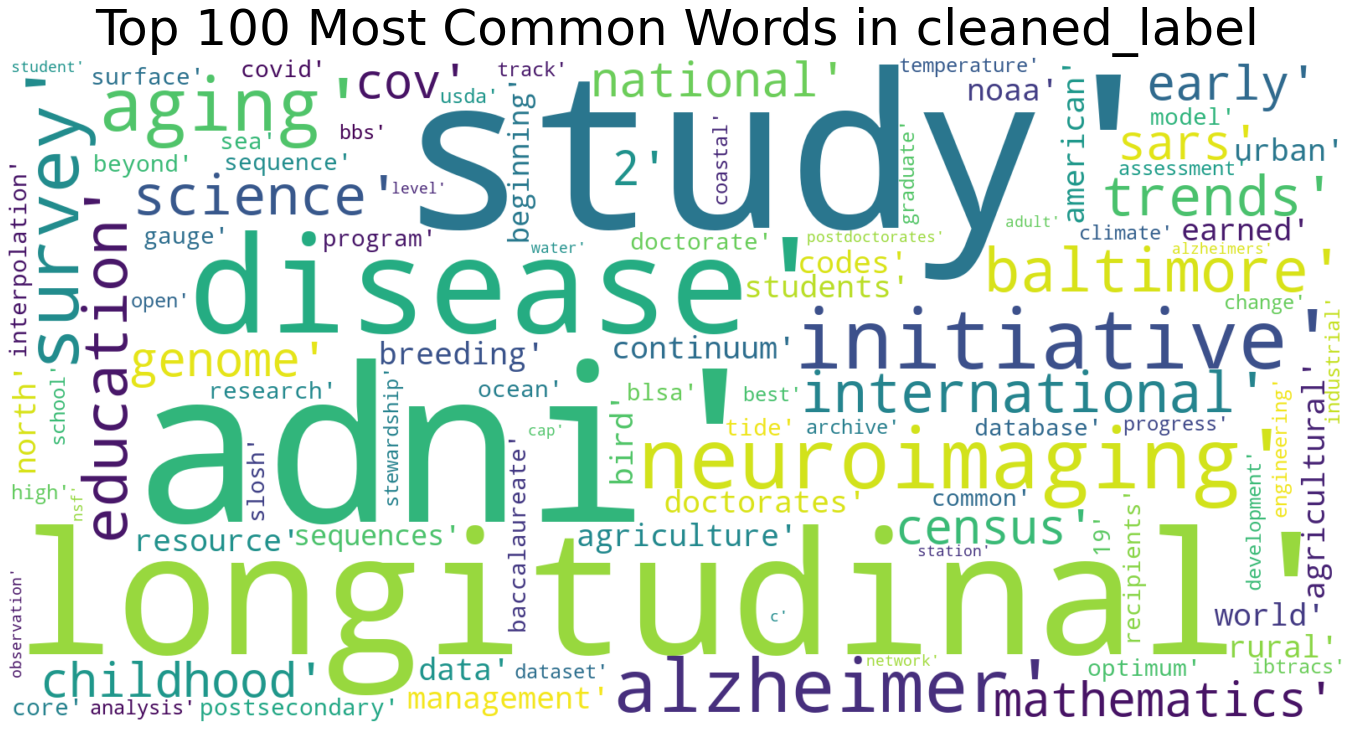

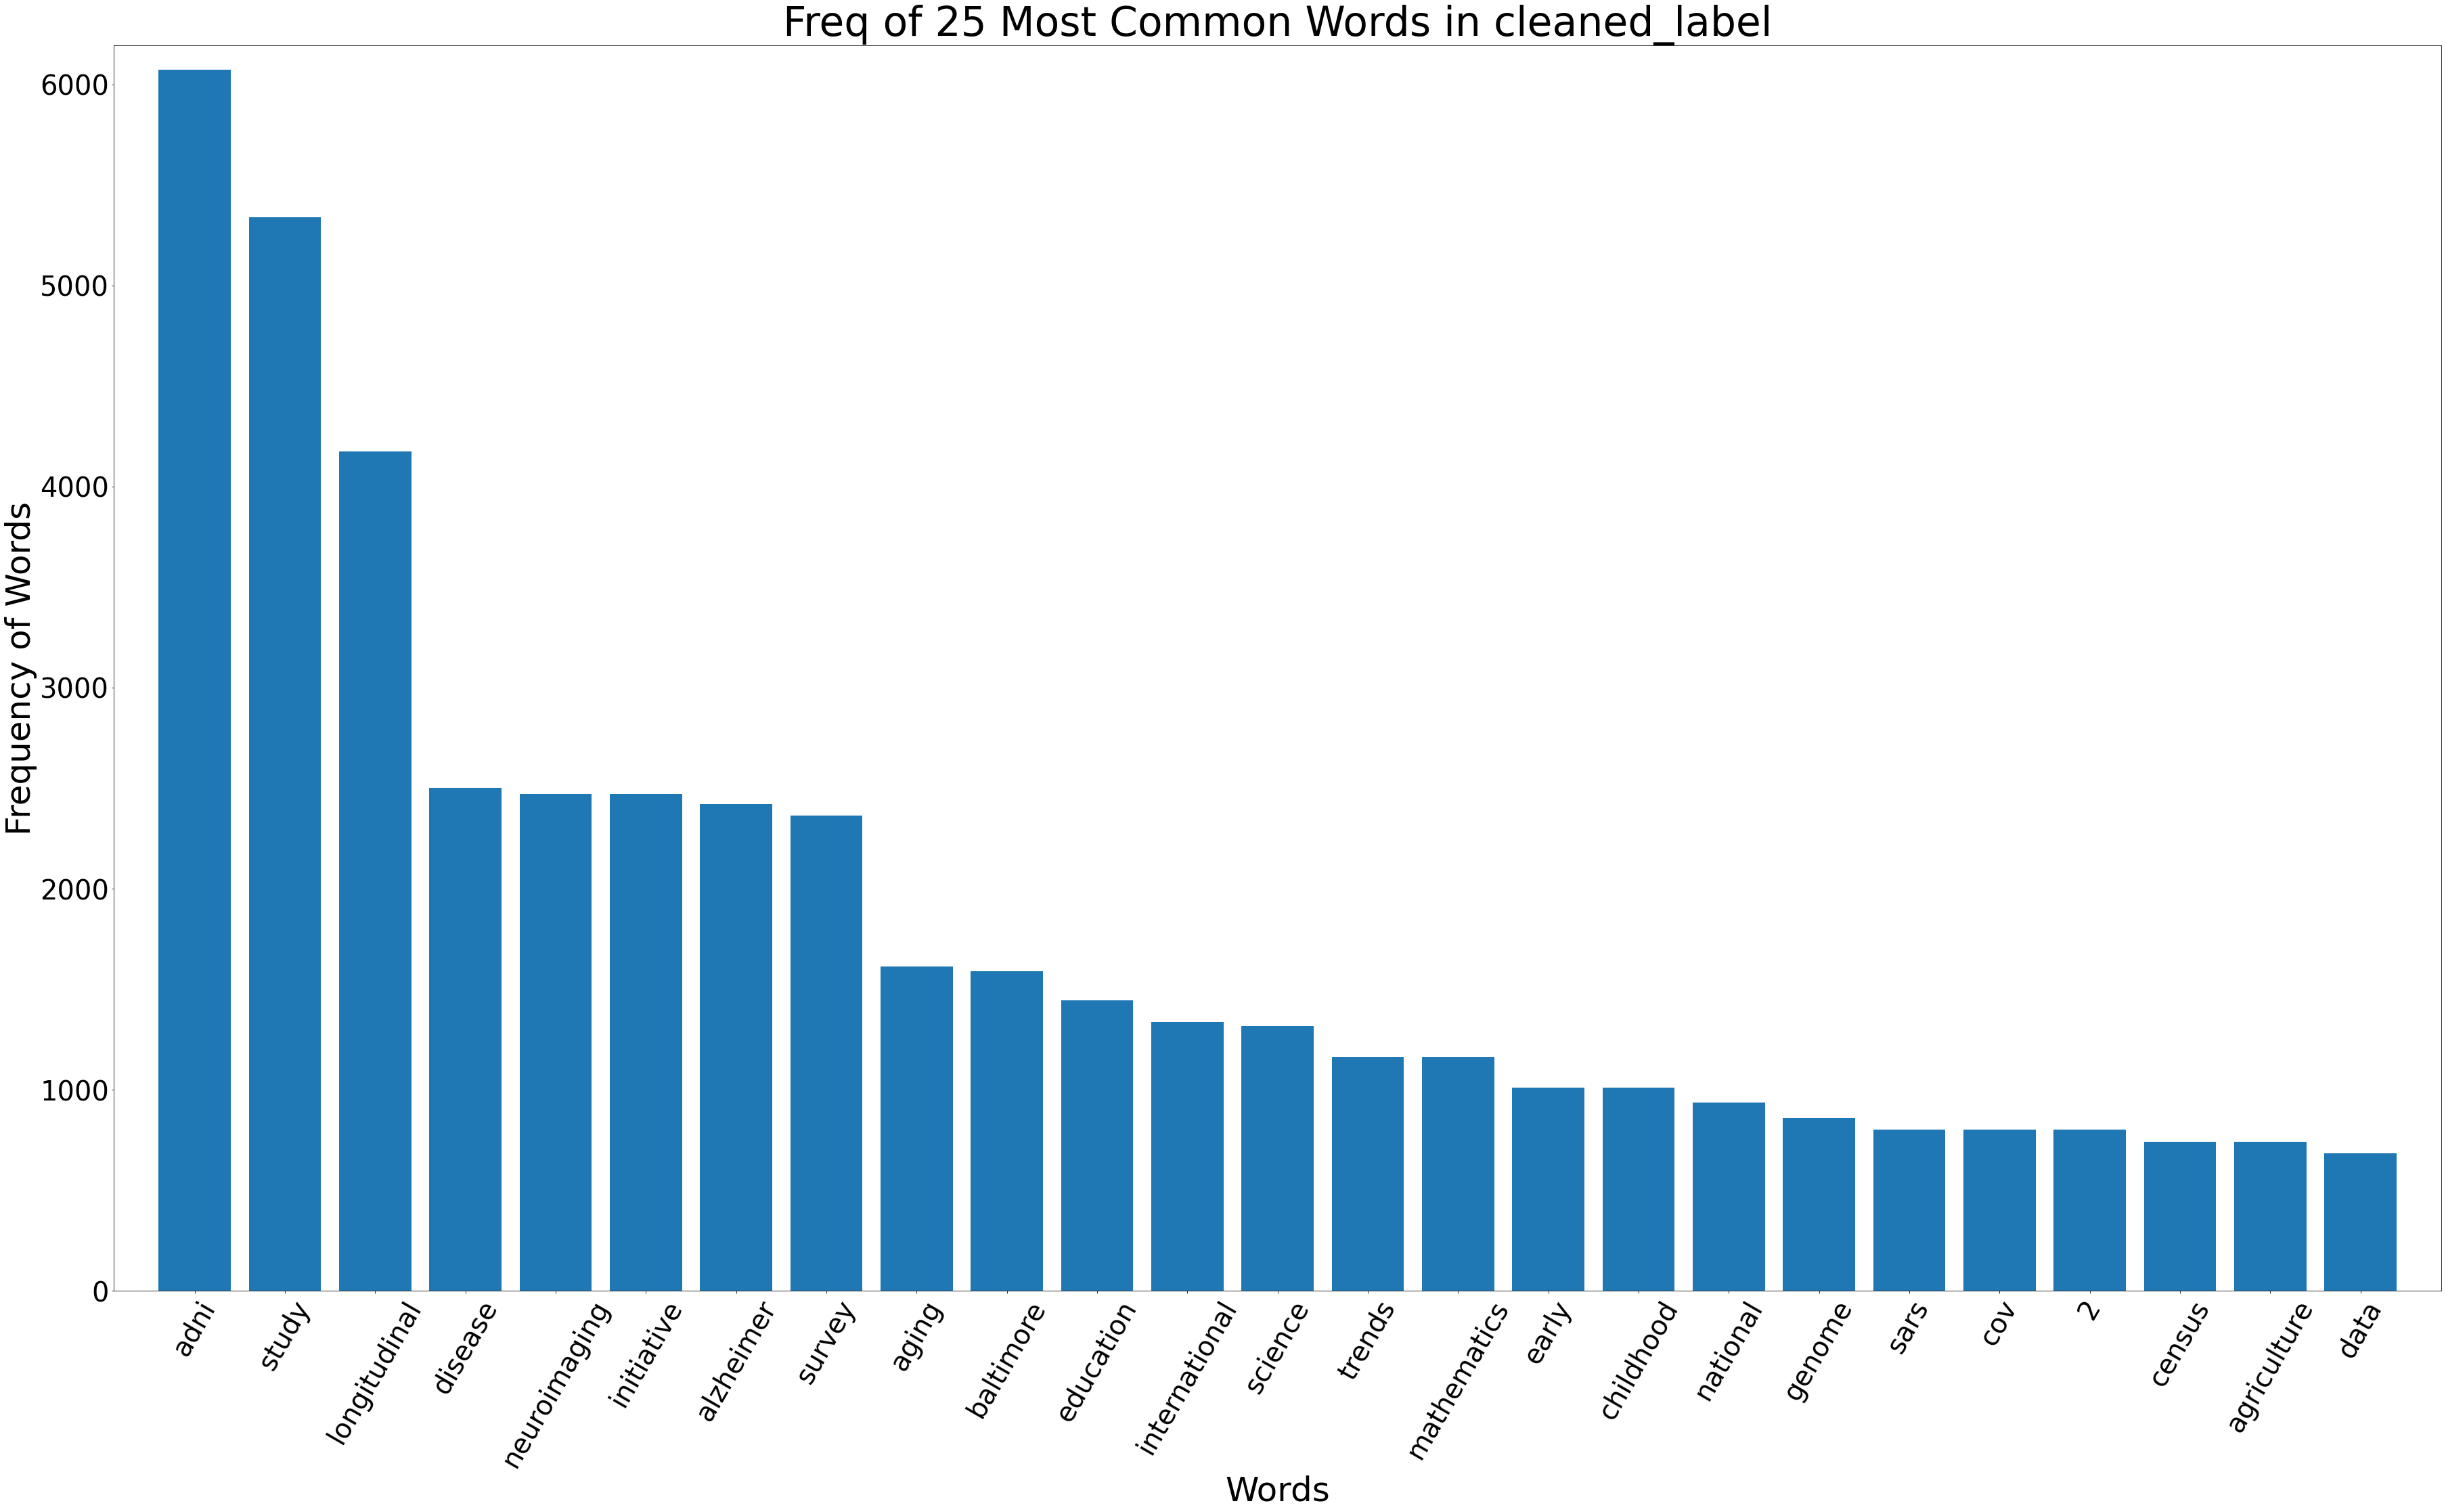

In [122]:
mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white', stopwords=STOPWORDS).generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words in cleaned_label', fontsize=50)
plt.tight_layout(pad=0)
plt.show()

mostcommon_small = FreqDist(allwords).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.tight_layout(pad=0)
plt.title('Freq of 25 Most Common Words in cleaned_label', fontsize=60)
plt.show()

In [123]:
def token_text(text, nlp=nlp):
    doc = nlp(text)
    lemma_list = [token.lemma_ for token in doc if not token.is_stop]
    lemmatized_sentence = ' '.join(lemma_list)
    
    return lemmatized_sentence

In [124]:
def clean_text(txt):
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower()).strip()

In [127]:
%%time
tqdm.pandas()
train_df['text'] = train_df['text'].progress_apply(token_text) 

ValueError: [E088] Text of length 10411675 exceeds maximum of 4000000. The parser and NER models require roughly 1GB of temporary memory per 100,000 characters in the input. This means long texts may cause memory allocation errors. If you're not using the parser or NER, it's probably safe to increase the `nlp.max_length` limit. The limit is in number of characters, so you can check whether your inputs are too long by checking `len(text)`.